In [38]:
# Data handling and statistical analysis 
import pandas as pd
from pandas_datareader import data
import numpy as np
from scipy import stats

# Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Optimization and allocation
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import black_litterman, BlackLittermanModel

# Financial data 
import quantstats as qs
import ta
import yfinance as yf

# Linear Regression Model
from sklearn.linear_model import LinearRegression

# Enabling Plotly offline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Datetime and hiding warnings 
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [39]:
# Getting daily returns for 4 different US stocks in the same time window
aapl = qs.utils.download_returns('AAPL')
aapl = aapl.loc['2015-07-01':'2025-02-10']
# 检查当前索引的时区信息
print(aapl.index.tzinfo)

# 如果没有时区（tz-naive），需要先 localize 处理
aapl.index = aapl.index.tz_localize("UTC").tz_convert(None)

# 再次检查是否成功去掉时区
print(aapl.index.tzinfo)

None
None





Apple Cumulative Returns Plot



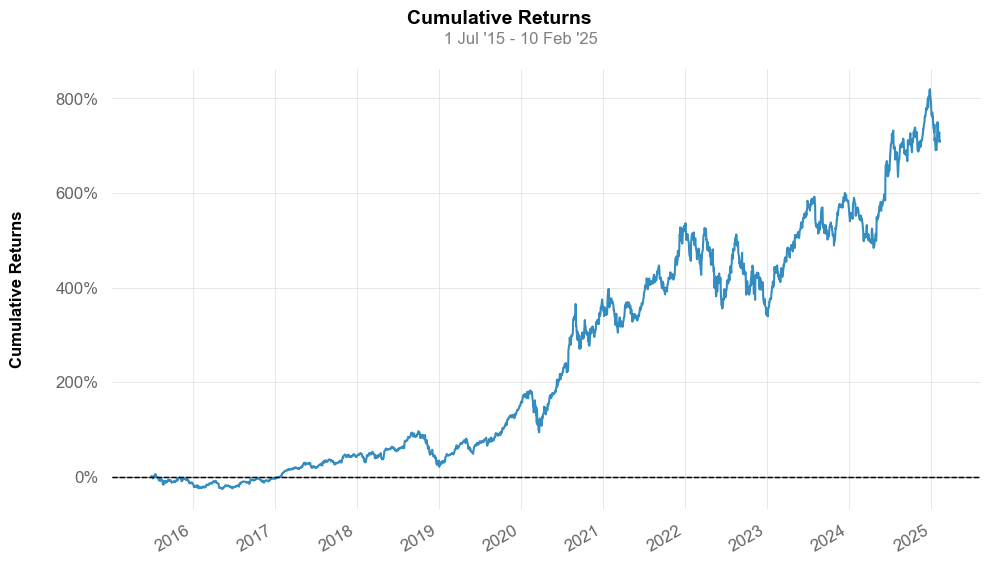

In [40]:
# Plotting Cumulative Returns for each stock
print('\n')
print('\nApple Cumulative Returns Plot\n')
qs.plots.returns(aapl)




Apple Daily Returns Histogram


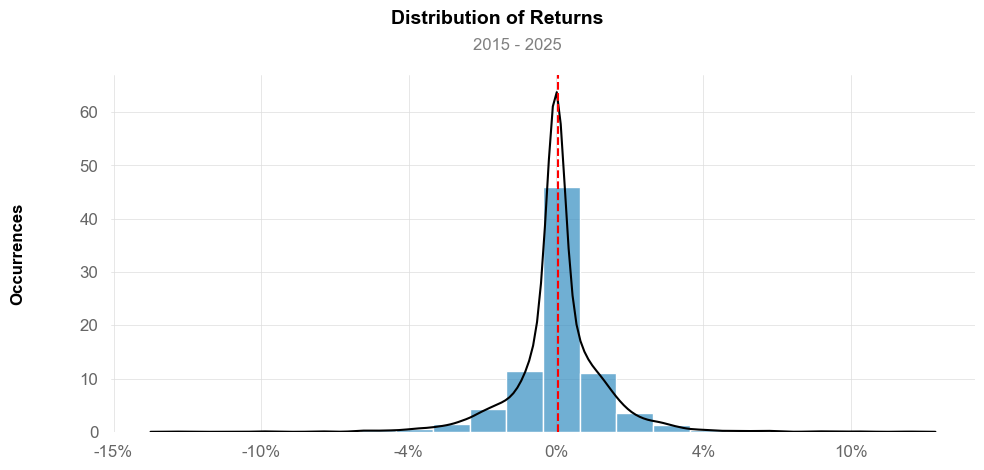

In [41]:
# Plotting histograms for daily returns 
print('\n')
print('\nApple Daily Returns Histogram')
qs.plots.histogram(aapl, resample = 'D')

### 收集 AAPL 历史价格数据

### 获取宏观经济数据

In [17]:
import pandas as pd
import datetime as dt
from pandas_datareader.data import DataReader
import yfinance as yf

# 定义时间范围（提前 1 年获取数据，以确保计算同比变化率）
start_date = '2014-01-01'  # 提前 1 年获取数据
actual_start_date = '2015-01-01'  # 需要最终保留的数据起点
actual_end_date = '2025-02-28'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

# 获取宏观数据
interest_rates = DataReader('DGS10', 'fred', start_date, end_date)  # 美国10年期国债收益率（每日）

# 获取 CPI 数据并计算通胀率
inflation = DataReader('CPIAUCSL', 'fred', start_date, end_date)
inflation['Inflation'] = inflation.pct_change(periods=12) * 100  # 计算 CPI YoY 变化率
inflation = inflation.loc[actual_start_date:]  # 仅保留 2015 年及以后的数据

# 获取 GDP 数据并计算 GDP 增长率
gdp = DataReader('GDP', 'fred', start_date, end_date)
gdp['GDP_Growth'] = gdp.pct_change(periods=4) * 100  # 计算 GDP YoY 变化率
gdp = gdp.loc[actual_start_date:]  # 仅保留 2015 年及以后的数据

# 获取 VIX（恐慌指数）
vix = DataReader('VIXCLS', 'fred', start_date, end_date)  # VIX 波动率指数（每日）

# 使用 Yahoo Finance 获取 DXY（美元指数）
dxy = yf.download('DX-Y.NYB', start=start_date, end=end_date)[['Close']]
dxy.rename(columns={'Close': 'DXY'}, inplace=True)  # 直接重命名列

# 处理时间不匹配（将低频数据转换为每日数据）
inflation = inflation[['Inflation']].resample('D').ffill()  # CPI 从月度变成每日
gdp = gdp[['GDP_Growth']].resample('D').ffill()  # GDP 从季度变成每日

# 读取用户提供的 AAPL 数据集
aapl = pd.read_csv('AAPL_post_adjusted_data.csv', parse_dates=['Date'], index_col='Date')

# 筛选 2015-01-01 至 2025-02-28 的数据
aapl = aapl.loc[actual_start_date:actual_end_date]

# 选择 AAPL 收盘价格作为 Price
aapl['Price'] = aapl['Close']

# 合并数据集
data = pd.concat([aapl['Price'], interest_rates, inflation, gdp, vix, dxy], axis=1)
data.columns = ['Price', 'Interest_Rate', 'Inflation', 'GDP_Growth', 'VIX', 'DXY']

# 让数据对齐到 AAPL 交易日
data = data.reindex(aapl.index)

# 用前值填充 NaN，防止数据丢失
data.ffill(inplace=True)

# 检查数据
print(data.head())  # 确保数据正确
print(data.tail())

data.to_csv('aapl_macro.csv')

[*********************100%***********************]  1 of 1 completed

                Price  Interest_Rate  Inflation  GDP_Growth    VIX        DXY
Date                                                                         
2015-01-02  24.320431           2.12  -0.229931    5.034331  17.79  91.080002
2015-01-05  23.635286           2.04  -0.229931    5.034331  19.92  91.379997
2015-01-06  23.637514           1.97  -0.229931    5.034331  21.12  91.500000
2015-01-07  23.968966           1.96  -0.229931    5.034331  19.31  91.889999
2015-01-08  24.889906           2.03  -0.229931    5.034331  17.01  92.370003
                 Price  Interest_Rate  Inflation  GDP_Growth    VIX  \
Date                                                                  
2025-02-24  247.100006           4.40   2.872366    5.027677  18.98   
2025-02-25  247.039993           4.30   2.872366    5.027677  19.43   
2025-02-26  240.360001           4.25   2.872366    5.027677  19.10   
2025-02-27  237.300003           4.29   2.872366    5.027677  21.13   
2025-02-28  241.839996      

In [8]:
print(data.index.min(), data.index.max())  # 查看数据索引范围

2015-01-02 00:00:00 2025-02-28 00:00:00


In [9]:
print(data.isna().sum())  # 查看每列缺失值数量

Price            0
Interest_Rate    0
Inflation        0
GDP_Growth       0
VIX              0
DXY              0
dtype: int64


In [10]:
print(aapl.index.max())  # 确保 AAPL 最新数据是 2025 年

2025-02-28 00:00:00


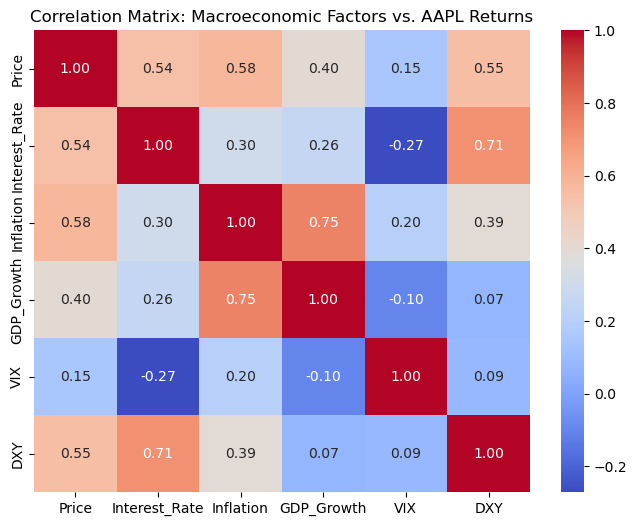

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算相关性矩阵
corr_matrix = data.corr()

# 绘制相关性热力图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Macroeconomic Factors vs. AAPL Returns")
plt.show()

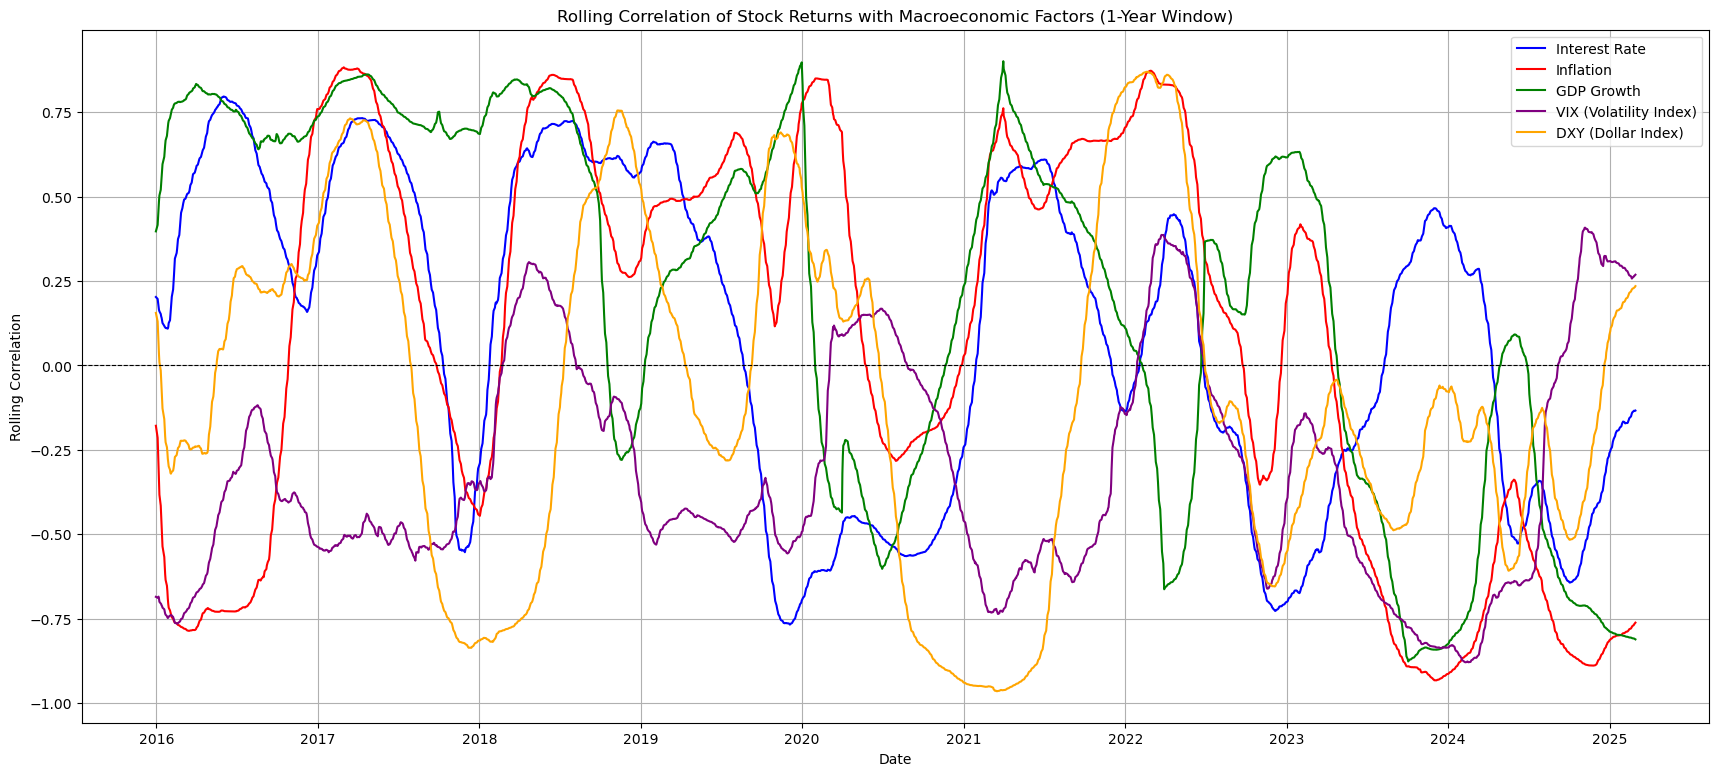

In [19]:
import matplotlib.pyplot as plt

# 计算滚动相关性（252 交易日窗口，大约 1 年）
rolling_window = 252
rolling_corr = data[['Price', 'Interest_Rate', 'Inflation', 'GDP_Growth', 'VIX', 'DXY']].rolling(rolling_window).corr()

# 仅保留 Price 的相关性数据
rolling_corr = rolling_corr.loc[(slice(None), 'Price'), :].unstack(level=1)

# 重新绘制滚动相关性图
plt.figure(figsize=(21, 9))
plt.plot(rolling_corr.index.get_level_values(0), rolling_corr['Interest_Rate'], label='Interest Rate', color='blue')
plt.plot(rolling_corr.index.get_level_values(0), rolling_corr['Inflation'], label='Inflation', color='red')
plt.plot(rolling_corr.index.get_level_values(0), rolling_corr['GDP_Growth'], label='GDP Growth', color='green')
plt.plot(rolling_corr.index.get_level_values(0), rolling_corr['VIX'], label='VIX (Volatility Index)', color='purple')
plt.plot(rolling_corr.index.get_level_values(0), rolling_corr['DXY'], label='DXY (Dollar Index)', color='orange')

plt.title("Rolling Correlation of Stock Returns with Macroeconomic Factors (1-Year Window)")
plt.xlabel("Date")
plt.ylabel("Rolling Correlation")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # 添加 0 轴参考线
plt.legend()
plt.grid(True)
plt.show()

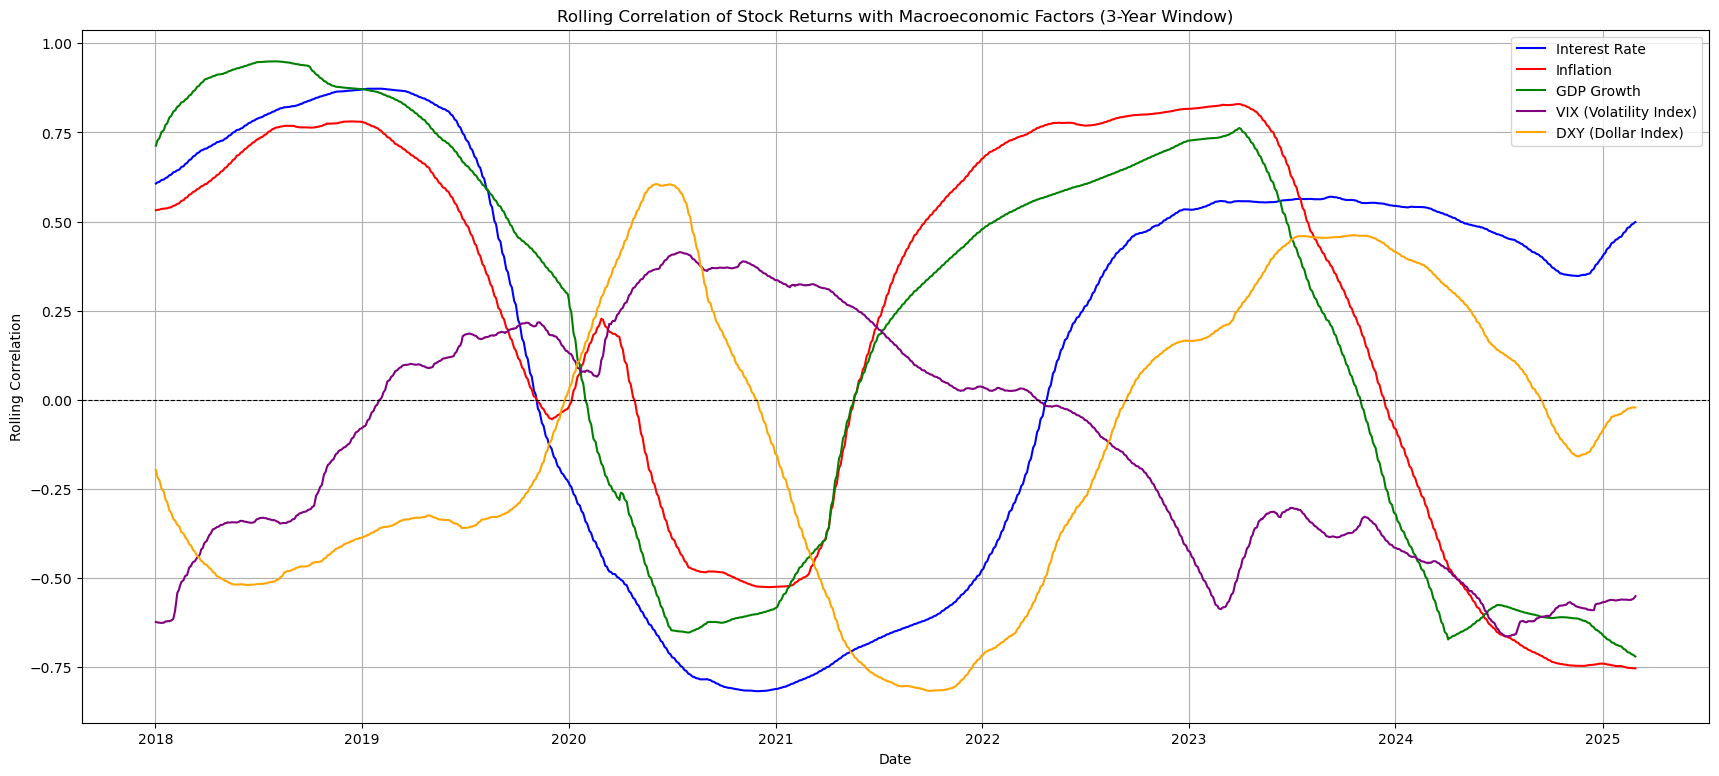

In [20]:
import matplotlib.pyplot as plt

# 计算滚动相关性（252 交易日窗口，大约 3 年）
rolling_window = 756
rolling_corr = data[['Price', 'Interest_Rate', 'Inflation', 'GDP_Growth', 'VIX', 'DXY']].rolling(rolling_window).corr()

# 仅保留 Stock_Return 的相关性数据
rolling_corr = rolling_corr.loc[(slice(None), 'Price'), :].unstack(level=1)

# 重新绘制滚动相关性图
plt.figure(figsize=(21, 9))
plt.plot(rolling_corr.index.get_level_values(0), rolling_corr['Interest_Rate'], label='Interest Rate', color='blue')
plt.plot(rolling_corr.index.get_level_values(0), rolling_corr['Inflation'], label='Inflation', color='red')
plt.plot(rolling_corr.index.get_level_values(0), rolling_corr['GDP_Growth'], label='GDP Growth', color='green')
plt.plot(rolling_corr.index.get_level_values(0), rolling_corr['VIX'], label='VIX (Volatility Index)', color='purple')
plt.plot(rolling_corr.index.get_level_values(0), rolling_corr['DXY'], label='DXY (Dollar Index)', color='orange')

plt.title("Rolling Correlation of Stock Returns with Macroeconomic Factors (3-Year Window)")
plt.xlabel("Date")
plt.ylabel("Rolling Correlation")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # 添加 0 轴参考线
plt.legend()
plt.grid(True)
plt.show()

Epoch [1/20], Loss: 0.0000
Epoch [2/20], Loss: 0.0002
Epoch [3/20], Loss: 0.0001
Epoch [4/20], Loss: 0.0001
Epoch [5/20], Loss: 0.0002
Epoch [6/20], Loss: 0.0001
Epoch [7/20], Loss: 0.0002
Epoch [8/20], Loss: 0.0002
Epoch [9/20], Loss: 0.0000
Epoch [10/20], Loss: 0.0001
Epoch [11/20], Loss: 0.0001
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 0.0001
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0001
Epoch [16/20], Loss: 0.0002
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0001


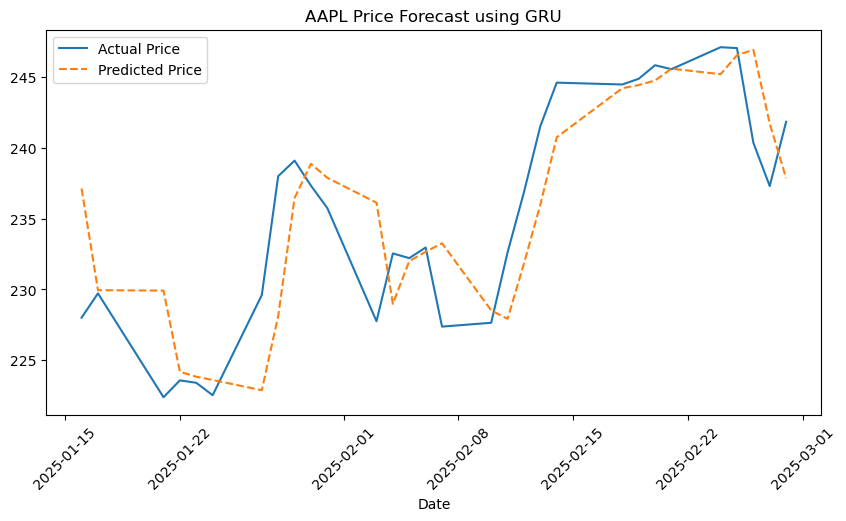

In [30]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 定义时间范围
actual_start_date = '2015-01-01'
actual_end_date = '2025-02-28'

# 读取数据
data = pd.read_csv('aapl_macro.csv', parse_dates=['Date'], index_col='Date')

# 选择研究变量
df = data[['Price', 'Interest_Rate', 'Inflation', 'GDP_Growth', 'VIX', 'DXY']]

# 归一化数据
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# 创建时间序列数据
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length, 0])  # 预测 Price
    return np.array(sequences), np.array(labels)

seq_length = 30  # 过去 30 天的数据来预测下一天
X, y = create_sequences(df_scaled, seq_length)

# 转换为 PyTorch 张量
X_train = torch.tensor(X[:-30], dtype=torch.float32)
y_train = torch.tensor(y[:-30], dtype=torch.float32)
X_test = torch.tensor(X[-30:], dtype=torch.float32)
y_test = torch.tensor(y[-30:], dtype=torch.float32)

dates = df.index[-30:]  # 获取最后 10 天的日期

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 定义 GRU 模型
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

# 初始化模型
input_size = df.shape[1]  # 变量个数
hidden_size = 64
num_layers = 2
model = GRUModel(input_size, hidden_size, num_layers)

# 训练模型
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20
for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 进行预测
model.eval()
y_pred = model(X_test).detach().numpy()

# 反归一化数据
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], df.shape[1]-1)))))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.numpy().reshape(-1,1), np.zeros((y_test.shape[0], df.shape[1]-1)))))[:, 0]

# 画出预测趋势（带时间轴）
plt.figure(figsize=(10, 5))
plt.plot(dates, y_test_rescaled, label='Actual Price')
plt.plot(dates, y_pred_rescaled, label='Predicted Price', linestyle='dashed')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title('AAPL Price Forecast using GRU')
plt.show()

Epoch [1/20], Loss: 0.0002
Epoch [2/20], Loss: 0.0003
Epoch [3/20], Loss: 0.0004
Epoch [4/20], Loss: 0.0000
Epoch [5/20], Loss: 0.0000
Epoch [6/20], Loss: 0.0000
Epoch [7/20], Loss: 0.0000
Epoch [8/20], Loss: 0.0001
Epoch [9/20], Loss: 0.0006
Epoch [10/20], Loss: 0.0001
Epoch [11/20], Loss: 0.0001
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0001
Epoch [15/20], Loss: 0.0005
Epoch [16/20], Loss: 0.0005
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0008
Epoch [19/20], Loss: 0.0002
Epoch [20/20], Loss: 0.0001


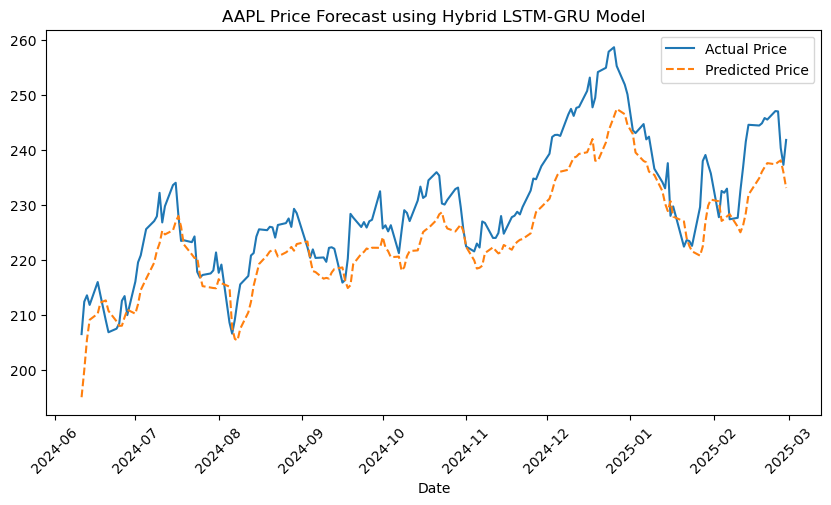

In [32]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 定义时间范围
actual_start_date = '2015-01-01'
actual_end_date = '2025-02-28'

# 读取数据
data = pd.read_csv('aapl_macro.csv', parse_dates=['Date'], index_col='Date')

# 选择研究变量
df = data[['Price', 'Interest_Rate', 'Inflation', 'GDP_Growth', 'VIX', 'DXY']]

# 归一化数据
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# 创建时间序列数据
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length, 0])  # 预测 Price
    return np.array(sequences), np.array(labels)

seq_length = 180  # 过去 180 天的数据来预测下一天
X, y = create_sequences(df_scaled, seq_length)

# 转换为 PyTorch 张量
X_train = torch.tensor(X[:-180], dtype=torch.float32)
y_train = torch.tensor(y[:-180], dtype=torch.float32)
X_test = torch.tensor(X[-180:], dtype=torch.float32)
y_test = torch.tensor(y[-180:], dtype=torch.float32)

dates = df.index[-180:]  # 获取最后 180 天的日期

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 定义 LSTM + GRU 混合模型
class HybridModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(HybridModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out, _ = self.gru(out)
        out = self.fc(out[:, -1, :])
        return out

# 初始化模型
input_size = df.shape[1]  # 变量个数
hidden_size = 64
num_layers = 2
model = HybridModel(input_size, hidden_size, num_layers)

# 训练模型
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20
for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 进行预测
model.eval()
y_pred = model(X_test).detach().numpy()

# 反归一化数据
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], df.shape[1]-1)))))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.numpy().reshape(-1,1), np.zeros((y_test.shape[0], df.shape[1]-1)))))[:, 0]

# 画出预测趋势（带时间轴）
plt.figure(figsize=(10, 5))
plt.plot(dates, y_test_rescaled, label='Actual Price')
plt.plot(dates, y_pred_rescaled, label='Predicted Price', linestyle='dashed')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title('AAPL Price Forecast using Hybrid LSTM-GRU Model')
plt.show()

---